https://medium.com/towards-data-science/how-to-benefit-from-the-semi-supervised-learning-with-label-spreading-algorithm-2f373ae5de96

**Label propagation** computes a similarity matrix between samples and uses a KNN-based approach to propagate samples, while **label spreading** takes a similar approach but adds a regularization to be more robust to noise. We restricted our experiment to label spreading for optimal performance.

The Label Spreading algorithm uses symmetric normalized graph Laplacian matrix in its calculations, while Label Propagation employs a random walk normalized Laplacian.

Label Propagation uses *hard clamping*, which means that the labels of the originally labeled points never change.

Meanwhile, Label Spreading adopts *soft clamping* controlled through a hyperparameter α (alpha), which specifies the relative amount of information the point obtains from its neighbors vs. its initial label information.

### Label spreading

In [1]:
# Data manipulation
import pandas as pd # for data manipulation

# Visualization
import plotly.express as px         # for data visualization
import plotly.graph_objects as go   # for data visualization
import matplotlib.pyplot as plt     # for showing confusion matrix

# Skleran
from sklearn.metrics import classification_report                       # for model evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay    # for showing confusion matrix
from sklearn.preprocessing import MinMaxScaler                          # for feature scaling
from sklearn.semi_supervised import LabelSpreading                      # for assigning labels to unlabeled data

In [7]:
# Read in data
df = pd.read_csv(
    "/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Marketing campaign/data/marketing_campaign.csv",
    encoding="utf-8",
    delimiter="\t",
    usecols=["ID", "Year_Birth", "Marital_Status", "Income", "Kidhome", "Teenhome", "MntWines", "MntMeatProducts"],
)
# Create a flag to denote whether the person has any dependants at home (either kids or teens)
df["Dependents_Flag"] = df.apply(lambda x: 1 if x["Kidhome"] + x["Teenhome"] > 0 else 0, axis=1)

# Randomly select 2% of observations to keep the label for. The rest of obs will have their labels masked
df["Rand_Selection"] = False
df.loc[df.sample(frac=0.02, random_state=42).index, "Rand_Selection"] = True

# Create a new target colum with labels. The 1's and 0's are original labels and -1 represents unlabeled (masked) data
df["Dependents_Target"] = df.apply(lambda x: x["Dependents_Flag"] if x["Rand_Selection"] == True else -1, axis=1)

# Show target value distribution
print("Target Value Distribution:")
print(df["Dependents_Target"].value_counts())

# Print dataframe
df.head()

Target Value Distribution:
-1    2195
 1      28
 0      17
Name: Dependents_Target, dtype: int64


,ID,Year_Birth,Marital_Status,Income,Kidhome,Teenhome,MntWines,MntMeatProducts,Dependents_Flag,Rand_Selection,Dependents_Target
0,5524,1957,Single,58138.0,0,0,635,546,0,False,-1
1,2174,1954,Single,46344.0,1,1,11,6,1,False,-1
2,4141,1965,Together,71613.0,0,0,426,127,0,False,-1
3,6182,1984,Together,26646.0,1,0,11,20,1,False,-1
4,5324,1981,Married,58293.0,1,0,173,118,1,False,-1


Note, we have kept 2% of the actual labels (1’s and 0’s) and masked the remainder 98% (-1’s). Hence, our target contains information on whether the shopper has any dependents (1), does not have any dependents (0), or this information is masked (-1).

In [8]:
# Create a scatter plot
fig = px.scatter(
    df,
    x="MntMeatProducts",
    y="MntWines",
    opacity=1,
    color=df["Dependents_Target"].astype(str),
    color_discrete_sequence=["lightgrey", "red", "blue"],
)

# Change chart background color
fig.update_layout(dict(plot_bgcolor="white"))

# Update axes lines
fig.update_xaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor="white",
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor="white",
    showline=True,
    linewidth=1,
    linecolor="white",
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor="white",
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor="white",
    showline=True,
    linewidth=1,
    linecolor="white",
)

# Set figure title
fig.update_layout(title_text="Marketing Campaign Data - Labeled vs. Unlabeled")

# Update marker size
fig.update_traces(marker=dict(size=5))

fig.show()


Model Name:  LabelSpreading(alpha=0.5, gamma=70, max_iter=100, n_jobs=-1)
Classes:  [0 1]
Label Distributions:  [[0.69991019 0.30008981]
 [0.23632714 0.76367286]
 [0.19742974 0.80257026]
 ...
 [0.45366299 0.54633701]
 [0.25090897 0.74909103]
 [0.2053455  0.7946545 ]]
Transduction Label:  [0 1 1 ... 1 1 1]
No. of features:  2
No. of iterations:  10

*************** Evaluation of LS model ***************
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       621
           1       0.83      0.95      0.88      1574

    accuracy                           0.82      2195
   macro avg       0.81      0.73      0.75      2195
weighted avg       0.82      0.82      0.81      2195


******************** Confusion Matrix ********************


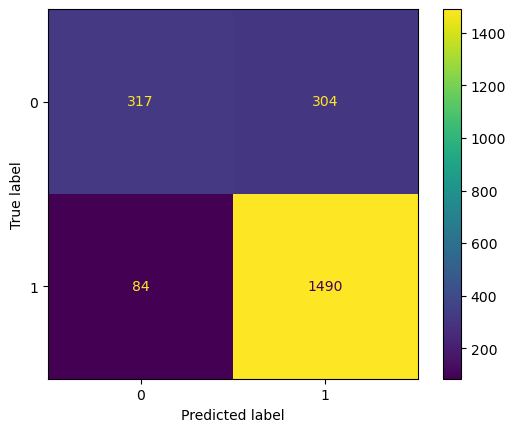

In [9]:
### Step 1 - Select data
X = df[["MntMeatProducts", "MntWines"]]
y = df["Dependents_Target"].values


### Step 2 - Perform Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


### Step 3 - Configure model parameters
model_LS = LabelSpreading(
    kernel="rbf",       # {'knn', 'rbf'} default='rbf'
    gamma=70,           # default=20, Parameter for rbf kernel.
    # n_neighbors=7,    # default=7, Parameter for knn kernel which is a strictly positive integer.
    alpha=0.5,          # Clamping factor. A value in (0, 1) that specifies the relative amount that an instance should adopt the information from its neighbors as opposed
                        # to its initial label. alpha=0 means keeping the initial label information; alpha=1 means replacing all initial information.
    max_iter=100,       # default=30, Maximum number of iterations allowed.
    tol=0.001,          # default=1e-3, Convergence tolerance: threshold to consider the system at steady state.
    n_jobs=-1,          # default=None, The number of parallel jobs to run. -1 means using all processors.
)

### Step 4 - Fit the model
LS = model_LS.fit(X_scaled, y)

### Step 5 - exclude observations with known records before evcaluating model performance
df_eval = df[["Dependents_Flag", "Dependents_Target"]].copy()  # Copy dataframe with dependents info
df_eval["Predicted_label"] = LS.transduction_  # Attach model predictions
df_eval = df_eval[df_eval["Dependents_Target"] == -1]  # Keep only records containing masked labels

### Step 6 - Print the summary of model results
print("Model Name: ", str(LS))
print("Classes: ", LS.classes_)
print("Label Distributions: ", LS.label_distributions_)
print("Transduction Label: ", LS.transduction_)
print("No. of features: ", LS.n_features_in_)
print("No. of iterations: ", LS.n_iter_)
print("")
print("*************** Evaluation of LS model ***************")
print(classification_report(df_eval["Dependents_Flag"], df_eval["Predicted_label"]))
print("")
print("******************** Confusion Matrix ********************")
cm = confusion_matrix(df_eval["Dependents_Flag"], df_eval["Predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LS.classes_)
disp.plot()
plt.show()


In [10]:
# Create a scatter plot
fig = px.scatter(
    df,
    x="MntMeatProducts",
    y="MntWines",
    opacity=1,
    color=LS.transduction_.astype(str),
    color_discrete_sequence=["blue", "red"],
)

# Change chart background color
fig.update_layout(dict(plot_bgcolor="white"))

# Update axes lines
fig.update_xaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor="white",
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor="white",
    showline=True,
    linewidth=1,
    linecolor="white",
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor="white",
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor="white",
    showline=True,
    linewidth=1,
    linecolor="white",
)

# Set figure title
fig.update_layout(title_text="Label Spreading model results")

# Update marker size
fig.update_traces(marker=dict(size=5))

fig.show()


### Label propagation

Semi-Supervised learning is

* Transductive learning: Transductive learning aims at classifying the unlabeled input data by exploiting the information derived from labeled data. It does not build the mapping function between the input data and target variable and hence learns a specific function for the input data. Example: Transductive Support vector machine(TSVM), Label Propagation Algorithm(LPA)
* Inductive learning: Learns from the labeled data and then predicts the unlabeled data. It draws conclusions based on observations and learns a generic function to map the input data to the target variable. Example: Traditional supervised learning algorithm.

A Label Propagation model is created using the respective class and trained on the labeled data using the fit method. Label Propagation is a type of semi-supervised learning that uses the underlying structure of the data to propagate labels from the labeled instances to the unlabeled instances. The basic idea is that instances that are close to each other in feature space are likely to have the same label. By propagating the labels from the labeled instances to the unlabeled instances, the model can make predictions for the unlabeled instances.

Label propagation makes a few assumptions.

* All classes for the dataset are present in the labeled data
* Data points that are close have similar labels
* Data points in the same cluster will likely have the same label

Label propagation creates a fully connected graph where the nodes are all the labeled and unlabeled data points.

The edges between the two nodes are weighted. The shorter the euclidean distance between two nodes, the larger the weight will be. A larger edge weight allows the label to travel easily.

https://medium.com/towards-data-science/semi-supervised-learning-how-to-assign-labels-with-label-propagation-algorithm-9f1683f4d0eb

In [15]:
# Read in data
df = pd.read_csv(
    "/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Marketing campaign/data/marketing_campaign.csv",
    encoding="utf-8",
    delimiter="\t",
    usecols=["ID", "Year_Birth", "Marital_Status", "Income", "Kidhome", "Teenhome", "MntWines", "MntMeatProducts"],
)
# Create a flag to denote whether the person has any dependants at home (either kids or teens)
df["Dependents_Flag"] = df.apply(lambda x: 1 if x["Kidhome"] + x["Teenhome"] > 0 else 0, axis=1)

# Randomly select 2% of observations to keep the label for. The rest of obs will have their labels masked
df["Rand_Selection"] = False
df.loc[df.sample(frac=0.02, random_state=42).index, "Rand_Selection"] = True

# Create a new target colum with labels. The 1's and 0's are original labels and -1 represents unlabeled (masked) data
df["Dependents_Target"] = df.apply(lambda x: x["Dependents_Flag"] if x["Rand_Selection"] == True else -1, axis=1)

# Show target value distribution
print("Target Value Distribution:")
print(df["Dependents_Target"].value_counts())

# Print dataframe
df.head()

Target Value Distribution:
-1    2195
 1      28
 0      17
Name: Dependents_Target, dtype: int64


,ID,Year_Birth,Marital_Status,Income,Kidhome,Teenhome,MntWines,MntMeatProducts,Dependents_Flag,Rand_Selection,Dependents_Target
0,5524,1957,Single,58138.0,0,0,635,546,0,False,-1
1,2174,1954,Single,46344.0,1,1,11,6,1,False,-1
2,4141,1965,Together,71613.0,0,0,426,127,0,False,-1
3,6182,1984,Together,26646.0,1,0,11,20,1,False,-1
4,5324,1981,Married,58293.0,1,0,173,118,1,False,-1


Model Name:  LabelPropagation(kernel='knn', n_jobs=-1, n_neighbors=20)
Classes:  [0 1]
Label Distributions:  [[0.58803964 0.41196036]
 [0.28930946 0.71069054]
 [0.14364458 0.85635542]
 ...
 [0.55938245 0.44061755]
 [0.27881901 0.72118099]
 [0.31229414 0.68770586]]
Transduction Label:  [0 1 1 ... 0 1 1]
No. of features:  2
No. of iterations:  904

*************** Evaluation of LP knn model ***************
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       621
           1       0.82      0.88      0.85      1574

    accuracy                           0.78      2195
   macro avg       0.73      0.70      0.71      2195
weighted avg       0.77      0.78      0.77      2195


******************** Confusion Matrix ********************


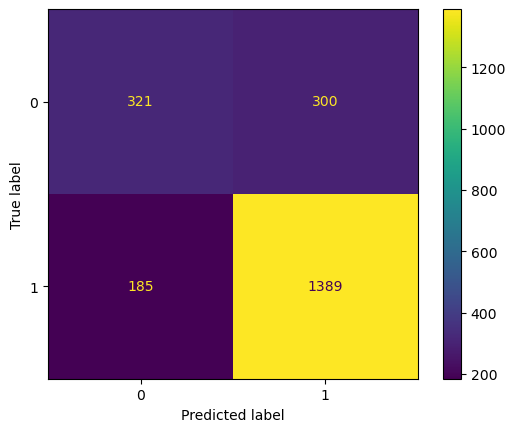

In [16]:
### Step 1 - Select data
X = df[["MntMeatProducts", "MntWines"]]
y = df["Dependents_Target"].values


### Step 2 - Perform Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


### Step 3 - Configure model parameters
model_LP_knn = LabelPropagation(
    kernel="knn",       # {'knn', 'rbf'} default='rbf'
    # gamma=70,         # default=20, Parameter for rbf kernel.
    n_neighbors=20,     # default=7, Parameter for knn kernel which is a strictly positive integer.
    max_iter=1000,      # default=30, Maximum number of iterations allowed.
    tol=0.001,          # default=1e-3, Convergence tolerance: threshold to consider the system at steady state.
    n_jobs=-1,          # default=None, The number of parallel jobs to run. -1 means using all processors.
)

### Step 4 - Fit the model
LP_knn = model_LP_knn.fit(X_scaled, y)

### Step 5 - exclude observations with known records before evcaluating model performance
df_eval = df[["Dependents_Flag", "Dependents_Target"]].copy()  # Copy dataframe with dependents info
df_eval["Predicted_label"] = LP_knn.transduction_  # Attach model predictions
df_eval = df_eval[df_eval["Dependents_Target"] == -1]  # Keep only records containing masked labels

### Step 6 - Print the summary of model results
print("Model Name: ", str(LP_knn))
print("Classes: ", LP_knn.classes_)
print("Label Distributions: ", LP_knn.label_distributions_)
print("Transduction Label: ", LP_knn.transduction_)
print("No. of features: ", LP_knn.n_features_in_)
print("No. of iterations: ", LP_knn.n_iter_)
print("")
print("*************** Evaluation of LP knn model ***************")
print(classification_report(df_eval["Dependents_Flag"], df_eval["Predicted_label"]))
print("")
print("******************** Confusion Matrix ********************")
cm = confusion_matrix(df_eval["Dependents_Flag"], df_eval["Predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LP_knn.classes_)
disp.plot()
plt.show()


In [17]:
# Specify a size of the mesh to be used
mesh_size = 10
margin = 0

# Create a mesh grid for displaying a threshold plane
x_min, x_max = df["MntMeatProducts"].min() - margin, df["MntMeatProducts"].max() + margin
y_min, y_max = df["MntWines"].min() - margin, df["MntWines"].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Set Z values to 0.5 for the threshold plane
Z = np.ones_like(xx) * 0.5


# Create a 3D scatter plot
fig = px.scatter_3d(
    df,
    x=df["MntMeatProducts"],
    y=df["MntWines"],
    z=LP_knn.label_distributions_[:, 1],
    color=df["Dependents_Flag"].astype("str"),
    color_discrete_sequence=["black", "red"],
    opacity=0.8,
    hover_data=[
        "Marital_Status",
        "MntWines",
        "Dependents_Target",
        "Dependents_Flag",
    ],
    height=900,
    width=900,
)

# Update chart looks
fig.update_layout(  # title_text="Scatter 3D Plot",
    showlegend=False,
    scene_camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=-0.2), eye=dict(x=-1.5, y=1.5, z=0.5)),
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(
            backgroundcolor="white",
            color="black",
            gridcolor="#f0f0f0",
            title_font=dict(size=10),
            tickfont=dict(size=10),
        ),
        yaxis=dict(
            backgroundcolor="white",
            color="black",
            gridcolor="#f0f0f0",
            title_font=dict(size=10),
            tickfont=dict(size=10),
        ),
        zaxis=dict(
            backgroundcolor="lightgrey",
            color="black",
            gridcolor="#f0f0f0",
            title_font=dict(size=10),
            title_text="Probability",
            tickfont=dict(size=10),
            dtick=0.1,
        ),
    ),
)

# Update marker size
fig.update_traces(marker=dict(size=3))

# Add prediction plane
fig.add_traces(go.Surface(x=xrange, y=yrange, z=Z, name="Separator", colorscale="Gray", opacity=0.5, showscale=False))

fig.show()


#### Cancer dataset

In [11]:
import numpy as np
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelPropagation

rnd = np.random.RandomState(42)
# load the cancer dataset
cancer = datasets.load_breast_cancer()

# Randomly unlabel some records in the dataset
# unlabeled points are marked as -1
random_unlabeled_points = rnd.rand(len(cancer.target)) < 0.6
labels = np.copy(cancer.target)
labels_orig = np.copy(cancer.target)
labels[random_unlabeled_points] = -1
X = cancer.data
tot_unlabled = labels[labels == -1]
print(f"Total Records in dataset is {len(X)} and unlabeled records is  {len(tot_unlabled)}")

# define model
model = LabelPropagation(kernel="knn", n_neighbors=5, gamma=30, max_iter=2000)
# fit model on training dataset
model.fit(X, labels)
# make predictions
predicted_labels = model.predict(X[random_unlabeled_points])
true_labels = labels_orig[random_unlabeled_points]

# print the classification report and confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=model.classes_)
print(
    "Label propagation model: %d labeled & %d unlabeled points (%d total)"
    % (len(labels[labels != -1]), len(tot_unlabled), len(X))
)

print(classification_report(true_labels, predicted_labels))
print("Confusion matrix")
print(cm)


Total Records in dataset is 569 and unlabeled records is  328
Label propagation model: 241 labeled & 328 unlabeled points (569 total)
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       128
           1       0.92      0.98      0.95       200

    accuracy                           0.93       328
   macro avg       0.94      0.92      0.93       328
weighted avg       0.94      0.93      0.93       328

Confusion matrix
[[110  18]
 [  4 196]]


There are several types of semi-supervised learning algorithms, including self-training, co-training, multi-view learning, and transductive learning.

### Self training

https://medium.com/@gayatri_sharma/a-gentle-introduction-to-semi-supervised-learning-7afa5539beea

Self-training is a simple semi-supervised learning method in which a model is first trained on the labeled data, and then used to label the unlabeled data. The labeled data and the newly labeled data are then combined and used to train a new model. This process is repeated until the model’s performance converges.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier

In [12]:
# Load the partially labeled data
X_train, y_train, X_unlabeled = load_data()

# Create the self-training classifier
clf = SelfTrainingClassifier(LogisticRegression())

# Fit the classifier to the labeled data
clf.fit(X_train, y_train)

# Use the classifier to label the unlabeled data
y_pred = clf.predict(X_unlabeled)

# Combine the labeled and newly labeled data and fit a new model
X_train_new = np.concatenate((X_train, X_unlabeled))
y_train_new = np.concatenate((y_train, y_pred))
clf.fit(X_train_new, y_train_new)


NameError: name 'load_data' is not defined

### Co-training

Co-training is a semi-supervised learning method that involves training two or more models on different views of the data, where a view is a different representation of the data. The models are then used to label the unlabeled data, and the labeled data and the newly labeled data are combined and used to train new models. This process is repeated until the models’ performance converges.

In [25]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample


class CoTrainingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator1, estimator2, max_iter=30, pool_size=50, confidence_threshold=0.75):
        self.estimator1 = estimator1
        self.estimator2 = estimator2
        self.max_iter = max_iter
        self.pool_size = pool_size
        self.confidence_threshold = confidence_threshold

    def fit(self, X_views, y):
        X1, X2 = X_views
        labeled_mask = y != -1
        unlabeled_mask = y == -1

        X1_labeled = X1[labeled_mask]
        X2_labeled = X2[labeled_mask]
        y_labeled = y[labeled_mask]

        X1_unlabeled = X1[unlabeled_mask]
        X2_unlabeled = X2[unlabeled_mask]

        self.estimator1.fit(X1_labeled, y_labeled)
        self.estimator2.fit(X2_labeled, y_labeled)

        for iteration in range(self.max_iter):
            # Sample a pool of unlabeled instances
            if len(X1_unlabeled) == 0 or len(X2_unlabeled) == 0:
                break

            X1_pool, X2_pool = resample(
                X1_unlabeled, X2_unlabeled, n_samples=min(self.pool_size, len(X1_unlabeled)), replace=False
            )

            # Predict with both classifiers
            y1_probs = self.estimator1.predict_proba(X1_pool)
            y2_probs = self.estimator2.predict_proba(X2_pool)

            # Select instances where classifiers are confident
            confident_indices1 = np.where(np.max(y1_probs, axis=1) >= self.confidence_threshold)[0]
            confident_indices2 = np.where(np.max(y2_probs, axis=1) >= self.confidence_threshold)[0]

            if len(confident_indices1) > 0:
                X1_labeled = np.vstack([X1_labeled, X1_pool[confident_indices1]])
                y_labeled = np.hstack([y_labeled, self.estimator1.predict(X1_pool[confident_indices1])])
                X1_unlabeled = np.delete(X1_unlabeled, confident_indices1, axis=0)
                X2_unlabeled = np.delete(X2_unlabeled, confident_indices1, axis=0)

            if len(confident_indices2) > 0:
                X2_labeled = np.vstack([X2_labeled, X2_pool[confident_indices2]])
                y_labeled = np.hstack([y_labeled, self.estimator2.predict(X2_pool[confident_indices2])])
                X1_unlabeled = np.delete(X1_unlabeled, confident_indices2, axis=0)
                X2_unlabeled = np.delete(X2_unlabeled, confident_indices2, axis=0)

            self.estimator1.fit(X1_labeled, y_labeled)
            self.estimator2.fit(X2_labeled, y_labeled)

        return self

    def predict(self, X_views):
        X1, X2 = X_views
        y1_pred = self.estimator1.predict(X1)
        y2_pred = self.estimator2.predict(X2)
        y_pred = (y1_pred + y2_pred) // 2
        return y_pred


# Example usage with the same data preparation
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    # Create a synthetic dataset
    X, y = make_classification(n_samples=200, n_features=20, n_informative=10, n_classes=2, random_state=42)

    # Split the dataset into two views
    X1 = X[:, :10]  # First 10 features
    X2 = X[:, 10:]  # Last 10 features

    # Split into labeled and unlabeled data
    X1_train, X1_unlabeled, y_train, y_unlabeled = train_test_split(X1, y, test_size=0.9, random_state=42)
    X2_train, X2_unlabeled, _, _ = train_test_split(X2, y, test_size=0.9, random_state=42)

    # Combine labeled and unlabeled data
    X1_combined = np.vstack([X1_train, X1_unlabeled])
    X2_combined = np.vstack([X2_train, X2_unlabeled])
    y_combined = np.concatenate([y_train, [-1] * len(y_unlabeled)])  # -1 for unlabeled data

    # Initialize the CoTrainingClassifier with two Logistic Regression models
    clf1 = LogisticRegression()
    clf2 = LogisticRegression()
    co_clf = CoTrainingClassifier(clf1, clf2)

    # Train the co-training classifier
    co_clf.fit([X1_combined, X2_combined], y_combined)

    # Predict on the original dataset (or use a separate test set)
    y_pred = co_clf.predict([X1, X2])
    accuracy = accuracy_score(y, y_pred)
    print(f"Final accuracy: {accuracy:.2f}")


ValueError: Found input variables with inconsistent numbers of samples: [55, 85]

### Label propagation with grid search cross-validation

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.semi_supervised import LabelPropagation

# Generate some synthetic data
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, random_state=0
)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Only keep a portion of the training data labeled
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

# Define the parameter grid for the hyperparameters to tune
param_grid = {"kernel": ["rbf", "knn"], "gamma": [0.1, 0.5, 1.0], "n_neighbors": [6, 7, 8]}

# Create a LabelPropagation model
model = LabelPropagation()

# Create a GridSearchCV object for the model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy")

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
